In [1]:
# Make module from local packages importable
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

In [3]:
file_path = "../data/raw/csv/adni_aibl_conv_strict.csv"
df = pd.read_csv(file_path)

# Different statistics about the number of images available

In [4]:
# Number of different patients
patient_labels = df.patient_label.unique()
print("Number of patients: {}".format(len(patient_labels)))

Number of patients: 2458


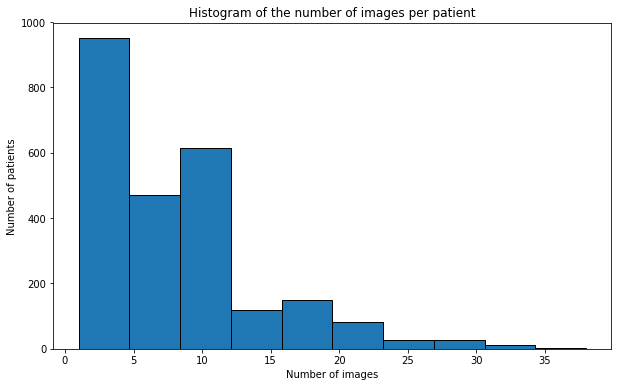

In [86]:
# Histogram of the number of images per patient
patient_count = df.groupby('patient_label').study_image_id.count()
plt.figure(figsize=(10,6))
patient_count.plot.hist(edgecolor='black')
plt.title("Histogram of the number of images per patient")
plt.xlabel("Number of images")
plt.ylabel("Number of patients")
plt.show()

In [87]:
# Patients with at least two images
patient_count = df.groupby('patient_label').study_image_id.count()
patient_count.columns = ['patient_label', "n_images"]

In [88]:
at_least_two = patient_count[patient_count >= 2]

In [89]:
print(patient_count.shape)
print(at_least_two.shape)

(2458,)
(2042,)


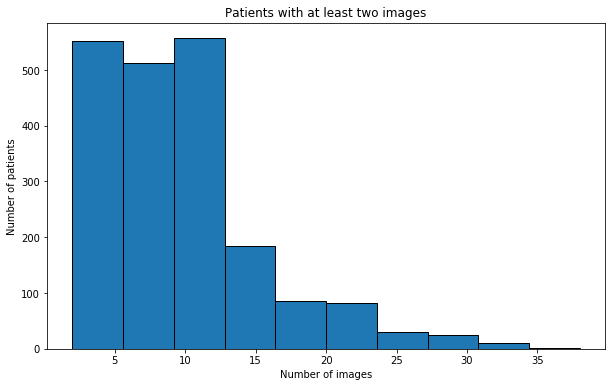

In [90]:
plt.figure(figsize=(10,6))
at_least_two.plot.hist(edgecolor='black')
plt.title("Patients with at least two images")
plt.xlabel("Number of images")
plt.ylabel("Number of patients")
plt.show()

In [91]:
# At least two images with the same age
patient_count_by_age = df.groupby(['patient_label', 'age']).study_image_id.count()

In [92]:
patient_count_by_age = patient_count_by_age.reset_index()
patient_count_by_age = patient_count_by_age.rename({"study_image_id": "n_images"}, axis='columns')
at_least_two = patient_count_by_age[patient_count_by_age.n_images >= 2]
print(patient_count_by_age.shape)
print(at_least_two.shape)

(7170, 3)
(5977, 3)


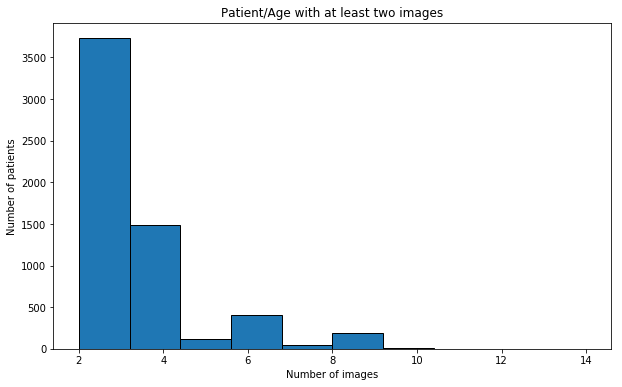

In [93]:
plt.figure(figsize=(10,6))
at_least_two.n_images.plot.hist(edgecolor='black')
plt.title("Patient/Age with at least two images")
plt.xlabel("Number of images")
plt.ylabel("Number of patients")
plt.show()

In [94]:
# Number of patients with at least two images per age
patient_labels = at_least_two.patient_label.unique()
len(patient_labels)

1843

# Diagnosis changes for patients

In [95]:
# df.groupby(['patient_label', 'age', 'healthy']).study_image_id.count().reset_index()

In [96]:
df = pd.read_csv(file_path)
records = df.to_dict('records')
# sort by label then by age, then by study_image_id

In [97]:
from operator import itemgetter as i
from functools import cmp_to_key

def cmp(a, b):
    return (a > b) - (a < b) 

def multikeysort(items, columns):
    comparers = [
        ((i(col[1:].strip()), -1) if col.startswith('-') else (i(col.strip()), 1))
        for col in columns
    ]
    def comparer(left, right):
        comparer_iter = (
            cmp(fn(left), fn(right)) * mult
            for fn, mult in comparers
        )
        return next((result for result in comparer_iter if result), 0)
    return sorted(items, key=cmp_to_key(comparer))

records = multikeysort(records, ['patient_label', 'age', 'study_image_id'])

In [98]:
import itertools
# Find patients for which the diagnosis changes (assuming records are ordered from earliest to latest)
patient_labels = []
classes = ["health_ad", "health_mci", "healthy"]
transitions = list(itertools.product(classes, classes))
trans_count = {}
trans_labels = {}
for t in transitions:
    trans_count[t] = 0
    trans_labels[t] = []

hc_to_ad = []
ad_to_hc = []
for i, r in enumerate(records):
    if i == 0:
        continue
        
    last = records[i - 1]

    if (r["patient_label"] == last["patient_label"]) and (r["healthy"] != last["healthy"]):
        patient_labels.append(r["patient_label"])
        if r["healthy"] == 1:
            ad_to_hc.append(r["patient_label"])
        else:
            hc_to_ad.append(r["patient_label"])

            
    if r["patient_label"] == last["patient_label"]:
        for a, b in transitions:
            if a == b:
                continue

            if (last[a] == 1) and (r[b] == 1):
                trans_count[(a, b)] += 1
                trans_labels[(a, b)].append(r["patient_label"])
                

In [99]:
print(len(patient_labels))
print(len(set(patient_labels)))

175
145


In [100]:
len(hc_to_ad)

111

In [101]:
len(ad_to_hc)

64

In [102]:
for k in trans_count:
    print("{}: {}, nbr distinct: {}".format(k, trans_count[k], len(set(trans_labels[k]))))

('health_ad', 'health_ad'): 0, nbr distinct: 0
('health_ad', 'health_mci'): 17, nbr distinct: 17
('health_ad', 'healthy'): 0, nbr distinct: 0
('health_mci', 'health_ad'): 299, nbr distinct: 293
('health_mci', 'health_mci'): 0, nbr distinct: 0
('health_mci', 'healthy'): 64, nbr distinct: 60
('healthy', 'health_ad'): 9, nbr distinct: 9
('healthy', 'health_mci'): 102, nbr distinct: 98
('healthy', 'healthy'): 0, nbr distinct: 0


In [103]:
for label in trans_labels[('health_mci', 'health_ad')]:
    c = trans_labels[('health_mci', 'health_ad')].count(label)
    if c > 1:
        print("{}: {}".format(label, c))

009_S_4741: 2
009_S_4741: 2
011_S_2274: 2
011_S_2274: 2
016_S_0702: 2
016_S_0702: 2
031_S_4947: 2
031_S_4947: 2
036_S_4430: 2
036_S_4430: 2
128_S_0135: 2
128_S_0135: 2


# Class distribution

In [104]:
df.groupby('health_emci').patient_label.count()

health_emci
0    19762
Name: patient_label, dtype: int64

In [105]:
df.groupby('health_lmci').patient_label.count()

health_lmci
0    19762
Name: patient_label, dtype: int64

In [106]:
df.groupby('health_smc').patient_label.count()

health_smc
0    19762
Name: patient_label, dtype: int64

### Mild cognitive impairment

In [107]:
df.groupby('health_mci').patient_label.count()

health_mci
0    11094
1     8668
Name: patient_label, dtype: int64

In [108]:
df.groupby(['healthy', 'health_mci']).patient_label.count()

healthy  health_mci
0        0             4476
         1             8668
1        0             6618
Name: patient_label, dtype: int64

In [109]:
df.groupby(['health_ad', 'health_mci']).patient_label.count()

health_ad  health_mci
0          0             6618
           1             8668
1          0             4476
Name: patient_label, dtype: int64

### AD, MCI, HC

In [5]:
df.groupby('healthy').patient_label.count()

healthy
0    13144
1     6616
Name: patient_label, dtype: int64

In [6]:
df.groupby('health_ad').patient_label.count()

health_ad
0    15284
1     4476
Name: patient_label, dtype: int64

In [8]:
df.groupby(['healthy', 'health_ad', 'health_mci', 'sex']).patient_label.count() / df.shape[0]

healthy  health_ad  health_mci  sex
0        0          1           0      0.266953
                                1      0.171711
         1          0           0      0.127277
                                1      0.099241
1        0          0           0      0.165233
                                1      0.169585
Name: patient_label, dtype: float64

In [9]:
df.groupby(['healthy', 'health_ad', 'health_mci', 'sex']).patient_label.count()

healthy  health_ad  health_mci  sex
0        0          1           0      5275
                                1      3393
         1          0           0      2515
                                1      1961
1        0          0           0      3265
                                1      3351
Name: patient_label, dtype: int64

In [10]:
df.groupby(['healthy', 'health_ad', 'health_mci']).patient_label.count()

healthy  health_ad  health_mci
0        0          1             8668
         1          0             4476
1        0          0             6616
Name: patient_label, dtype: int64

In [115]:
df.groupby(['healthy', 'health_ad', 'health_mci']).patient_label.count().sum()

19762

### By gender

In [116]:
df.groupby(['healthy', 'health_ad', 'health_mci', 'sex']).patient_label.count().to_latex("adni_aibl_summ_counts.csv", header=True)
df.groupby(['healthy', 'health_ad', 'health_mci', 'sex']).patient_label.count()

healthy  health_ad  health_mci  sex
0        0          1           0      5275
                                1      3393
         1          0           0      2515
                                1      1961
1        0          0           0      3265
                                1      3353
Name: patient_label, dtype: int64

In [117]:
(df.groupby(['healthy', 'health_ad', 'health_mci', 'sex']).patient_label.count() / df.shape[0]).to_latex("adni_aibl_summ_perc.csv", header=True)

### Apply some filters before computing stats

In [118]:
# f = df.groupby('patient_label', group_keys=False).apply(lambda df: df.sample(1))  # keep one row per patient

In [119]:
f.groupby(['healthy', 'health_ad', 'health_mci', 'sex']).patient_label.count()

AttributeError: '_io.TextIOWrapper' object has no attribute 'groupby'

In [ ]:
f.groupby(['healthy', 'health_ad', 'health_mci', 'sex']).patient_label.count() / df.shape[0]

In [ ]:
df.groupby('patient_label', group_keys=False).apply(lambda df: df.sample(1)).shape

## Multi-site analysis

In [133]:
# Distinct manufacturer
manus = df['mri_manufacturer'].unique()

In [134]:
print(manus)
len(manus)

['GE MEDICAL SYSTEMS' 'Philips Medical Systems' 'SIEMENS'
 'SIEMENS|PixelMed' 'Philips Healthcare']


5

In [135]:
# Number of images per manufacturer
df.groupby('mri_manufacturer').count().patient_label

mri_manufacturer
GE MEDICAL SYSTEMS         3932
Philips Healthcare           22
Philips Medical Systems    1750
SIEMENS                    5386
SIEMENS|PixelMed              4
Name: patient_label, dtype: int64

In [136]:
# How many different manufacturers per patient
manus_by_patient = df.groupby('patient_label').mri_manufacturer.unique()

In [137]:
distinct_manus_per_patient = [len(r) for r in manus_by_patient.values]

(array([1647.,    0.,    0.,    0.,    0.,  123.,    0.,    0.,    0.,
           2.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

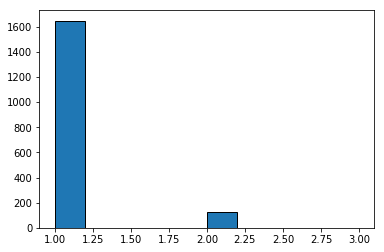

In [138]:
plt.hist(distinct_manus_per_patient, edgecolor='black')

In [139]:
# Verify calculation
patient_to_manus = {}
with open(file_path, 'r') as f:
    reader = csv.DictReader(f)
    for r in reader:
        patient = r["patient_label"]
        manu = r["mri_manufacturer"]
        if patient not in patient_to_manus:
            patient_to_manus[patient] = set([])
            
        patient_to_manus[patient].add(manu)
        
size_to_count = {}
for k, v in patient_to_manus.items():
    s = len(v)
    if s not in size_to_count:
        size_to_count[s] = 1
    else:
        size_to_count[s] += 1
        
for k, v in size_to_count.items():
    print("size {}, count {}".format(k, v))

size 2, count 123
size 1, count 1647
size 3, count 2


In [140]:
# More stats per manufacturer (diagnosis, gender, age)
manu_to_df = {}
for man in manus:
    manu_to_df[man] = df.loc[df['mri_manufacturer'] == man]

--------> GE MEDICAL SYSTEMS
Distinct patients 481
Number of images 3932
healthy  health_ad  health_mci
0        1          0             1702
1        0          0             2230
Name: patient_label, dtype: int64
healthy  health_ad  health_mci
0        1          0             0.432859
1        0          0             0.567141
Name: patient_label, dtype: float64
sex
0    2110
1    1822
Name: patient_label, dtype: int64
Mean age: 76.08163784333672
Std age: 6.750923870543353


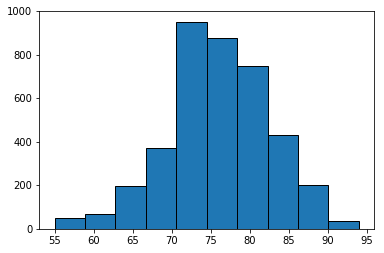

--------> Philips Medical Systems
Distinct patients 242
Number of images 1750
healthy  health_ad  health_mci
0        1          0              710
1        0          0             1040
Name: patient_label, dtype: int64
healthy  health_ad  health_mci
0        1          0             0.405714
1        0          0             0.594286
Name: patient_label, dtype: float64
sex
0    966
1    784
Name: patient_label, dtype: int64
Mean age: 74.81714285714285
Std age: 6.534107686999512


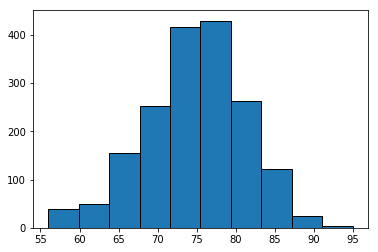

--------> SIEMENS
Distinct patients 1167
Number of images 5386
healthy  health_ad  health_mci
0        1          0             2055
1        0          0             3331
Name: patient_label, dtype: int64
healthy  health_ad  health_mci
0        1          0             0.381545
1        0          0             0.618455
Name: patient_label, dtype: float64
sex
0    2687
1    2699
Name: patient_label, dtype: int64
Mean age: 75.26921648718901
Std age: 7.002143272934389


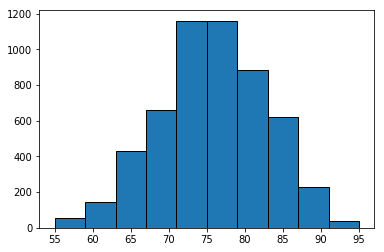

--------> SIEMENS|PixelMed
Distinct patients 2
Number of images 4
healthy  health_ad  health_mci
0        1          0             2
1        0          0             2
Name: patient_label, dtype: int64
healthy  health_ad  health_mci
0        1          0             0.5
1        0          0             0.5
Name: patient_label, dtype: float64
sex
1    4
Name: patient_label, dtype: int64
Mean age: 72.0
Std age: 11.0


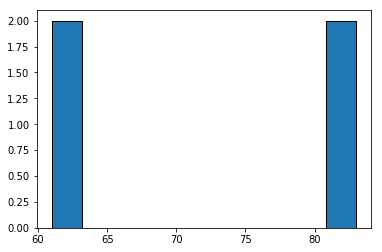

--------> Philips Healthcare
Distinct patients 7
Number of images 22
healthy  health_ad  health_mci
0        1          0              7
1        0          0             15
Name: patient_label, dtype: int64
healthy  health_ad  health_mci
0        1          0             0.318182
1        0          0             0.681818
Name: patient_label, dtype: float64
sex
0    17
1     5
Name: patient_label, dtype: int64
Mean age: 68.68181818181819
Std age: 5.964945809678132


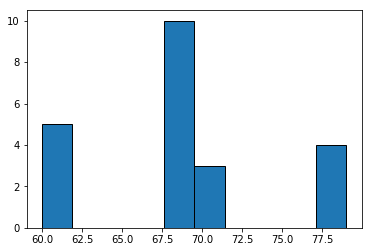

In [141]:
for k, v in manu_to_df.items():
    print("--------> {}".format(k))
    print("Distinct patients {}".format(len(v.patient_label.unique())))
    print("Number of images {}".format(len(v)))
    r = v.groupby(['healthy', 'health_ad', 'health_mci']).patient_label.count()
    print(r)
    r = v.groupby(['healthy', 'health_ad', 'health_mci']).patient_label.count() / v.shape[0]
    print(r)
    r = v.groupby('sex').patient_label.count()
    print(r)
    r = v.groupby('sex').patient_label.count() / v.shape[0]
    
    # Age distribution
    ages = v.age
    print("Mean age: {}".format(np.mean(ages)))
    print("Std age: {}".format(np.std(ages)))
    plt.figure()
    plt.hist(ages, edgecolor='black')
    plt.show()

### Common patients among manufacturers

In [142]:
n = len(manus)
for i in range(n):
    for j in range(i + 1, n):
        s1 = set(manu_to_df[manus[i]].patient_label.unique())
        s2 = set(manu_to_df[manus[j]].patient_label.unique())
        
        print("{} and {} have {} in common".format(manus[i], manus[j], len(s1.intersection(s2))))

GE MEDICAL SYSTEMS and Philips Medical Systems have 33 in common
GE MEDICAL SYSTEMS and SIEMENS have 67 in common
GE MEDICAL SYSTEMS and SIEMENS|PixelMed have 0 in common
GE MEDICAL SYSTEMS and Philips Healthcare have 5 in common
Philips Medical Systems and SIEMENS have 22 in common
Philips Medical Systems and SIEMENS|PixelMed have 0 in common
Philips Medical Systems and Philips Healthcare have 0 in common
SIEMENS and SIEMENS|PixelMed have 2 in common
SIEMENS and Philips Healthcare have 0 in common
SIEMENS|PixelMed and Philips Healthcare have 0 in common


In [148]:
q = df.groupby('patient_label').count().sex
labels = q.index.values
counts = q.values
patient_image_count = {}
for lab, c in zip(labels, counts):
    patient_image_count[lab] = c
# Number of patients and images per manufacturer after subtracting common patients
for i in range(n):
    man = manus[i]
    patients = set(manu_to_df[man].patient_label.unique())
    init_count = len(patients)
    for j in range(0, n):
        if i != j:
            s = set(manu_to_df[manus[j]].patient_label.unique())
            patients = patients.difference(s)
    
    print("{}, {}/{} patients remaining".format(man, len(patients), init_count))
    image_count = sum(patient_image_count[lab] for lab in patients)
    print("Image count {}".format(image_count))

GE MEDICAL SYSTEMS, 378/481 patients remaining
Image count 3142
Philips Medical Systems, 189/242 patients remaining
Image count 1369
SIEMENS, 1078/1167 patients remaining
Image count 4791
SIEMENS|PixelMed, 0/2 patients remaining
Image count 0
Philips Healthcare, 2/7 patients remaining
Image count 7


In [147]:
df.groupby('patient_label').count().sex.index.values

array(['002_S_0295', '002_S_0413', '002_S_0559', ..., '99', '993', '995'],
      dtype=object)

In [37]:
def age_stats(min_age, max_age, df):
    d = df.loc[(df['age_exact'] >= min_age) & (df['age_exact'] < max_age)]
    r = d.groupby(['healthy', 'health_ad', 'health_mci']).patient_label.count()
    print(r)
    r = d.groupby(['healthy', 'health_ad', 'health_mci', 'sex']).patient_label.count()
    print(r)
    print("Unique patients HC: {}".format(len(d.loc[d["healthy"] == 1].patient_label.unique())))
    print("Unique patients AD: {}".format(len(d.loc[d["health_ad"] == 1].patient_label.unique())))
    print("Unique patients MCI: {}".format(len(d.loc[d["health_mci"] == 1].patient_label.unique())))
    print("Unique patients men HC: {}".format(len(d.loc[(d["healthy"] == 1) & (d["sex"] == 0)].patient_label.unique())))
    print("Unique patients men AD: {}".format(len(d.loc[(d["health_ad"] == 1) & (d["sex"] == 0)].patient_label.unique())))
    print("Unique patients men MCI: {}".format(len(d.loc[(d["health_mci"] == 1) & (d["sex"] == 0)].patient_label.unique())))

In [47]:
age_stats(0, 9000, df)

healthy  health_ad  health_mci
0        0          1             8668
         1          0             4476
1        0          0             6616
Name: patient_label, dtype: int64
healthy  health_ad  health_mci  sex
0        0          1           0      5275
                                1      3393
         1          0           0      2515
                                1      1961
1        0          0           0      3265
                                1      3351
Name: patient_label, dtype: int64
Unique patients HC: 1052
Unique patients AD: 743
Unique patients MCI: 1104
Unique patients men HC: 486
Unique patients men AD: 412
Unique patients men MCI: 645


In [18]:
df

,health_ad,patient_label,sex,health_emci,mri_manufacturer,health_lmci,health_smc,dataset,health_mci,study_patient_id,...,age_exact,weighting,mci_ad_conv_delta_1,mci_ad_conv_delta_2,mci_ad_conv_delta_3,mci_ad_conv_delta_4,mci_ad_conv_delta_5,mci_ad_conv_delta_6,mci_ad_conv_delta_7,n_conversions
0,0,002_S_0295,0,0,GE MEDICAL SYSTEMS,0,0,train,0,93801557,...,84.9041,T1,-1,-1,-1,-1,-1,-1,-1,0
1,0,002_S_0295,0,0,GE MEDICAL SYSTEMS,0,0,train,0,93801557,...,84.9041,T1,-1,-1,-1,-1,-1,-1,-1,0
2,0,002_S_0295,0,0,GE MEDICAL SYSTEMS,0,0,train,0,93801557,...,85.4466,T1,-1,-1,-1,-1,-1,-1,-1,0
3,0,002_S_0295,0,0,GE MEDICAL SYSTEMS,0,0,train,0,93801557,...,85.4466,T1,-1,-1,-1,-1,-1,-1,-1,0
4,0,002_S_0295,0,0,GE MEDICAL SYSTEMS,0,0,train,0,93801557,...,86.0055,T1,-1,-1,-1,-1,-1,-1,-1,0
5,0,002_S_0295,0,0,GE MEDICAL SYSTEMS,0,0,train,0,93801557,...,86.0055,T1,-1,-1,-1,-1,-1,-1,-1,0
6,0,002_S_0295,0,0,GE MEDICAL SYSTEMS,0,0,train,0,93801557,...,87.1699,T1,-1,-1,-1,-1,-1,-1,-1,0
7,0,002_S_0295,0,0,GE MEDICAL SYSTEMS,0,0,train,0,93801557,...,87.1699,T1,-1,-1,-1,-1,-1,-1,-1,0
8,0,002_S_0295,0,0,GE MEDICAL SYSTEMS,0,0,train,0,93801557,...,88.0000,T1,-1,-1,-1,-1,-1,-1,-1,0
9,0,002_S_0295,0,0,GE MEDICAL SYSTEMS,0,0,train,0,93801557,...,88.0000,T1,-1,-1,-1,-1,-1,-1,-1,0
